In [32]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


In [2]:
unemployment_df = pd.read_csv("https://storage.googleapis.com/cs163-seniorproject.appspot.com/dataset/unemployment_rate/unemployment_rate_clean.csv")
cpi_df = pd.read_csv("https://storage.googleapis.com/cs163-seniorproject.appspot.com/dataset/cpi_rate/cpi_rate_clean.csv")
income_df = pd.read_csv("https://storage.googleapis.com/cs163-seniorproject.appspot.com/dataset/income/income_clean.csv")
poverty_df = pd.read_csv("https://storage.googleapis.com/cs163-seniorproject.appspot.com/dataset/poverty/poverty_clean.csv")

In [3]:
cpi_df['Inflation'] = cpi_df['CPI'].pct_change() * 100

In [4]:
monthly_df = pd.DataFrame({
    'Month': pd.date_range(start='2013-01-01', end='2023-12-01', freq='MS')
})
monthly_df['Year'] = monthly_df['Month'].dt.year

In [5]:
#add unemployment rate
unemployment_df['Month'] = pd.to_datetime(unemployment_df['Month'])
monthly_df = monthly_df.merge(unemployment_df, on='Month', how='left')

In [6]:
#add CPI
cpi_df['Month'] = pd.to_datetime(cpi_df['Month'])
monthly_df = monthly_df.merge(cpi_df, on='Month', how='left')
monthly_df['Inflation'] = monthly_df['Inflation'].interpolate(method='linear')  # linear method

In [7]:
# add income
monthly_df = monthly_df.merge(income_df, on='Year', how='left')

In [8]:
# add poverty
monthly_df = monthly_df.merge(poverty_df, on='Year', how='left')

In [9]:
w_unemp = 0.4     # Unemployment Rate (%)
w_poverty = 0.3   # Poverty Rate (%)
w_inflation = 0.2 # Inflation Rate (%)
w_income = 0.1    # Income Growth (%)

In [10]:
# normalize all columns
scaler = MinMaxScaler()
monthly_df[['norm_unemp', 'norm_inf', 'norm_income', 'norm_poverty']] = scaler.fit_transform(
    monthly_df[['Unemployment', 'Inflation', 'Median_Household_Income', 'Poverty Rate (%)']]
)

In [11]:
monthly_df['Stress_Score'] = (
    0.4 * monthly_df['norm_unemp'] +
    0.3 * monthly_df['norm_poverty'] +
    0.2 * monthly_df['norm_inf'] -
    0.1 * monthly_df['norm_income']
)

In [12]:
monthly_df['Stress_Score']

0           NaN
1           NaN
2           NaN
3      0.594158
4      0.578739
         ...   
127    0.109986
128    0.114177
129    0.130018
130    0.099461
131    0.072788
Name: Stress_Score, Length: 132, dtype: float64

In [13]:
monthly_df['Stress_Score'] = (
    (monthly_df['Stress_Score'] - monthly_df['Stress_Score'].min()) /
    (monthly_df['Stress_Score'].max() - monthly_df['Stress_Score'].min())
) * 100

In [14]:
monthly_df['Stress_Score'] = monthly_df['Stress_Score'].interpolate(method='linear') 

In [15]:
monthly_df.columns

Index(['Month', 'Year', 'Unemployment', 'CPI', 'Inflation',
       'Median_Household_Income', 'Poverty Rate (%)', 'norm_unemp', 'norm_inf',
       'norm_income', 'norm_poverty', 'Stress_Score'],
      dtype='object')

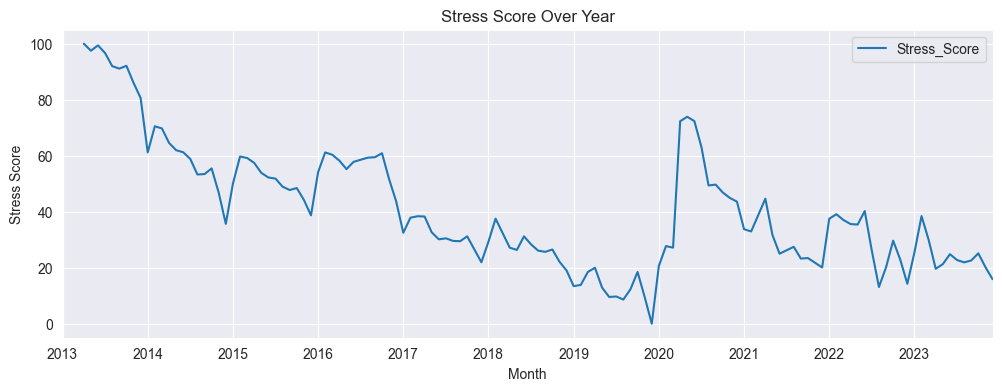

In [16]:
monthly_df.plot(x='Month', y='Stress_Score', figsize=(12, 4), title='Stress Score Over Year')
plt.ylabel('Stress Score')
plt.grid(True)
plt.show()

In [18]:
#merge 911 df
calls_df = pd.read_csv("https://storage.googleapis.com/cs163-seniorproject.appspot.com/dataset/911_calls/911_calls_clean.csv")
calls_df['Month'] = pd.to_datetime(calls_df['OFFENSE_DATE']).dt.to_period("M").dt.to_timestamp()
monthly_calls = calls_df.groupby("OFFENSE_DATE").size().reset_index(name="Call_Count")
monthly_calls = monthly_calls.rename(columns={'OFFENSE_DATE': 'Month'})
monthly_calls['Month'] = pd.to_datetime(monthly_calls['Month'])

In [19]:
final_df = monthly_calls.merge(monthly_df[['Month', 'Stress_Score']], on='Month', how='left')

In [20]:
final_df['Stress_Score'] = final_df['Stress_Score'].ffill()

In [21]:
final_df['Year'] = final_df['Month'].dt.year
final_df['Month_Num'] = final_df['Month'].dt.month

In [22]:
stress_median = final_df['Stress_Score'].median()
calls_df['Month'] = pd.to_datetime(calls_df['OFFENSE_DATE']).dt.to_period("M").dt.to_timestamp()

# Merge stress score into calls
merged = calls_df.merge(final_df[['Month', 'Stress_Score']], on='Month', how='left')

# Label each call with High or Low Stress Month
merged['Stress_Level'] = merged['Stress_Score'].apply(
    lambda x: 'High Stress' if x >= stress_median else 'Low Stress'
)


In [23]:
call_dist = merged.groupby(['Stress_Level', 'CALL_TYPE']).size().unstack().fillna(0)

# Normalize to get % distribution
call_dist_percent = call_dist.div(call_dist.sum(axis=1), axis=0) * 100


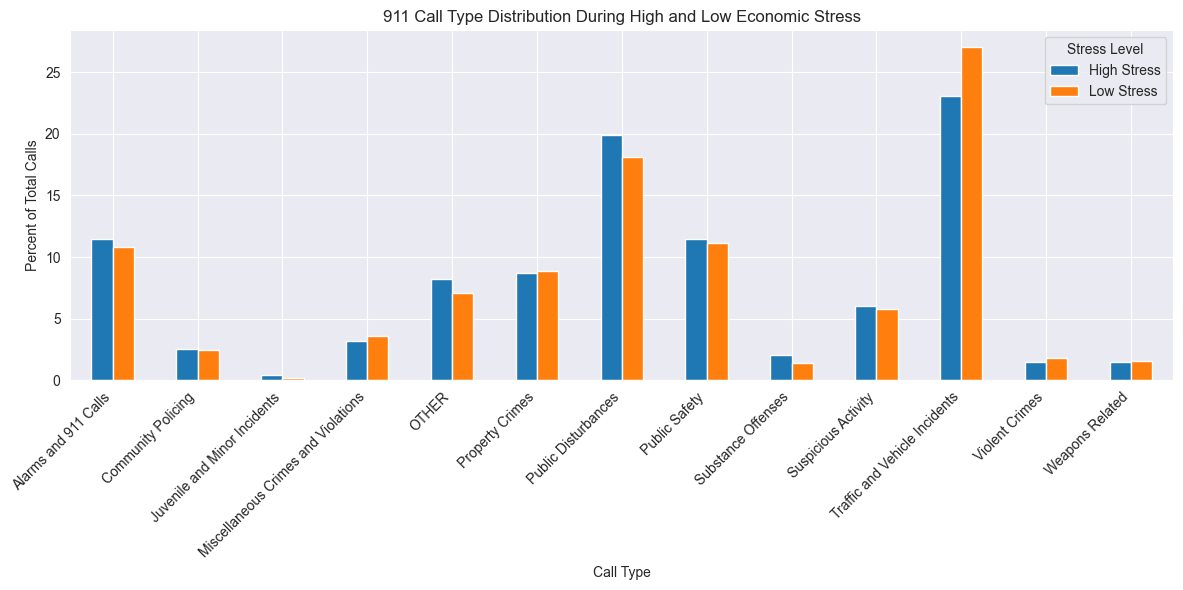

In [25]:
import matplotlib.pyplot as plt

call_dist_percent.T.plot(kind='bar', figsize=(12, 6))
plt.title("911 Call Type Distribution During High and Low Economic Stress")
plt.ylabel("Percent of Total Calls")
plt.xlabel("Call Type")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Stress Level")
plt.tight_layout()
plt.grid(True)
plt.show()


In [27]:
# Load Data
calls_df = pd.read_csv("https://storage.googleapis.com/cs163-seniorproject.appspot.com/dataset/911_calls/911_calls_clean.csv")
weather_df = pd.read_csv("https://storage.googleapis.com/cs163-seniorproject.appspot.com/dataset/weather/weather_clean.csv")

# Ensure date columns are datetime
calls_df['OFFENSE_DATE'] = pd.to_datetime(calls_df['OFFENSE_DATE'])
weather_df['DATE'] = pd.to_datetime(weather_df['DATE'])

# Get monthly call volume
calls_df['Year'] = calls_df['OFFENSE_DATE'].dt.year
calls_df['Month'] = calls_df['OFFENSE_DATE'].dt.month
monthly_calls = calls_df.groupby(['Year', 'Month']).size().reset_index(name='Call_Volume')

# Get monthly average temperature
weather_df['Year'] = weather_df['DATE'].dt.year
weather_df['Month'] = weather_df['DATE'].dt.month
monthly_temp = weather_df.groupby(['Year', 'Month'])['TAVG'].mean().reset_index()

# Merge call volume + avg temp
call_weather_df = pd.merge(monthly_calls, monthly_temp, on=['Year', 'Month'], how='inner')
# First, make sure 'Month' in monthly_df is a datetime
monthly_df['Month'] = pd.to_datetime(monthly_df['Month'])

# Then extract real Month and Year
monthly_df['Real_Month'] = monthly_df['Month'].dt.month
monthly_df['Real_Year'] = monthly_df['Month'].dt.year


# Merge with monthly economic indicators (monthly_df)
full_df = pd.merge(
    call_weather_df,
    monthly_df[['Real_Year', 'Real_Month', 'Stress_Score']],
    left_on=['Year', 'Month'],
    right_on=['Real_Year', 'Real_Month'],
    how='inner'
)
# Drop rows where TAVG or Stress_Score is NaN
full_df = full_df.dropna(subset=['TAVG', 'Stress_Score', 'Call_Volume'])

# Linear Regression
X = full_df[['TAVG', 'Stress_Score']]   # Features: Temperature and Stress Score
y = full_df['Call_Volume']              # Target: Call Volume

model = LinearRegression()
model.fit(X, y)

# Coefficients
coef_temp, coef_stress = model.coef_
intercept = model.intercept_

# R² score
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

# Results
print(f"Intercept: {intercept:.2f}")
print(f"Temperature Coefficient: {coef_temp:.2f}")
print(f"Stress Score Coefficient: {coef_stress:.2f}")
print(f"R² score: {r2:.2f}")


Intercept: 15768.92
Temperature Coefficient: 159.29
Stress Score Coefficient: 3.25
R² score: 0.41


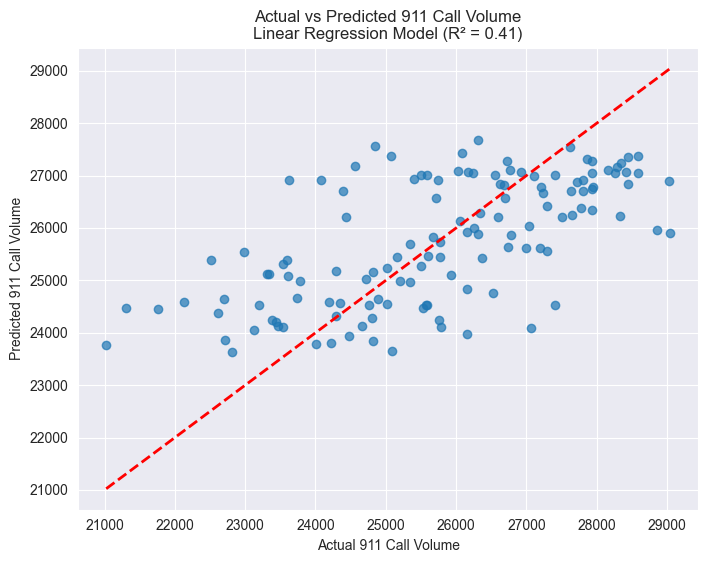

In [29]:
# After fitting the model and predicting
y_pred = model.predict(X)

# Create scatter plot
plt.figure(figsize=(8,6))
plt.scatter(y, y_pred, alpha=0.7)

# Plot perfect prediction line
max_val = max(max(y), max(y_pred))
min_val = min(min(y), min(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2)

plt.xlabel('Actual 911 Call Volume')
plt.ylabel('Predicted 911 Call Volume')
plt.title('Actual vs Predicted 911 Call Volume\nLinear Regression Model (R² = {:.2f})'.format(r2))
plt.grid(True)
plt.show()


In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# MODEL A: Weather only
X_weather = full_df[['TAVG']]
y = full_df['Call_Volume']

weather_model = LinearRegression()
weather_model.fit(X_weather, y)
y_pred_weather = weather_model.predict(X_weather)

intercept_weather = weather_model.intercept_
coef_weather = weather_model.coef_[0]
r2_weather = r2_score(y, y_pred_weather)

print("Weather Only Model")
print(f"Intercept: {intercept_weather:.2f}")
print(f"Temperature Coefficient: {coef_weather:.2f}")
print(f"R² score: {r2_weather:.2f}")
print()

# MODEL B: Economic Stress only
X_econ = full_df[['Stress_Score']]

econ_model = LinearRegression()
econ_model.fit(X_econ, y)
y_pred_econ = econ_model.predict(X_econ)

intercept_econ = econ_model.intercept_
coef_econ = econ_model.coef_[0]
r2_econ = r2_score(y, y_pred_econ)

print("Economic Stress Only Model")
print(f"Intercept: {intercept_econ:.2f}")
print(f"Stress Score Coefficient: {coef_econ:.2f}")
print(f"R² score: {r2_econ:.2f}")


Weather Only Model
Intercept: 15840.32
Temperature Coefficient: 160.28
R² score: 0.41

Economic Stress Only Model
Intercept: 25395.81
Stress Score Coefficient: 8.69
R² score: 0.01


In [31]:
# Convert to datetime
calls_df['OFFENSE_DATE'] = pd.to_datetime(calls_df['OFFENSE_DATE'])
weather_df['DATE'] = pd.to_datetime(weather_df['DATE'])

# Daily 911 call volume
daily_calls = calls_df.groupby('OFFENSE_DATE').size().reset_index(name='CALL_VOLUME')

# Merge with daily weather
daily_df = pd.merge(daily_calls, weather_df[['DATE', 'TAVG']], left_on='OFFENSE_DATE', right_on='DATE')

# Drop missing
daily_df = daily_df.dropna(subset=['TAVG'])


In [33]:

X = daily_df[['TAVG']]
y = daily_df['CALL_VOLUME']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

print(f"R² score for daily temperature model: {r2:.2f}")
print(f"Coefficient: {model.coef_[0]:.2f}")
print(f"Intercept: {model.intercept_:.2f}")


R² score for daily temperature model: 0.17
Coefficient: 4.08
Intercept: 586.05


In [34]:
# Merge more weather features
daily_weather = weather_df[['DATE', 'TAVG', 'TMAX', 'TMIN', 'RAIN']]
daily_df = pd.merge(daily_calls, daily_weather, left_on='OFFENSE_DATE', right_on='DATE')
daily_df = daily_df.dropna()

# Train model with all weather features
X = daily_df[['TAVG', 'TMAX', 'TMIN', 'RAIN']]
y = daily_df['CALL_VOLUME']

model.fit(X, y)
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

print(f"Daily model with multiple weather features - R²: {r2:.2f}")


Daily model with multiple weather features - R²: 0.38


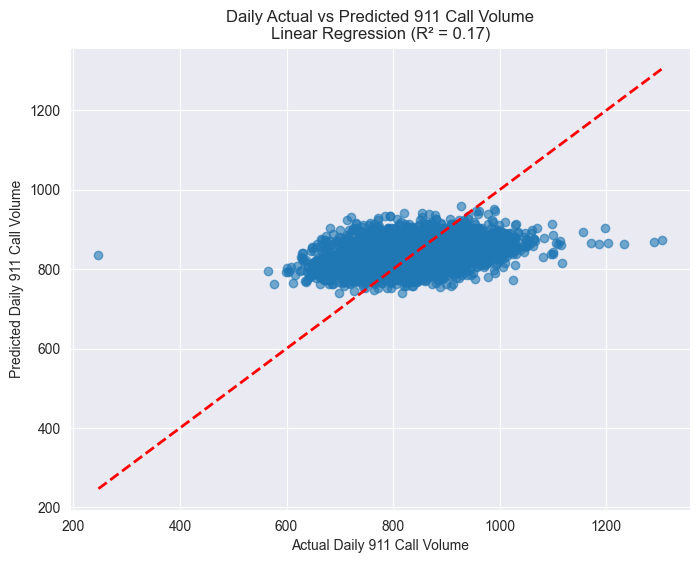

In [35]:
# Convert dates
calls_df['OFFENSE_DATE'] = pd.to_datetime(calls_df['OFFENSE_DATE'])
weather_df['DATE'] = pd.to_datetime(weather_df['DATE'])

# Daily 911 call volume
daily_calls = calls_df.groupby('OFFENSE_DATE').size().reset_index(name='CALL_VOLUME')

# Merge daily calls with daily weather
daily_df = pd.merge(daily_calls, weather_df[['DATE', 'TAVG']], left_on='OFFENSE_DATE', right_on='DATE')
daily_df = daily_df.dropna(subset=['TAVG'])

# Train the model
X = daily_df[['TAVG']]
y = daily_df['CALL_VOLUME']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

# Plot Actual vs Predicted
plt.figure(figsize=(8,6))
plt.scatter(y, y_pred, alpha=0.6)

# Perfect prediction line
min_val = min(min(y), min(y_pred))
max_val = max(max(y), max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2)

plt.xlabel('Actual Daily 911 Call Volume')
plt.ylabel('Predicted Daily 911 Call Volume')
plt.title(f'Daily Actual vs Predicted 911 Call Volume\nLinear Regression (R² = {r2:.2f})')
plt.grid(True)
plt.show()


In [36]:
# Prepare daily calls
daily_calls['Year'] = daily_calls['OFFENSE_DATE'].dt.year
daily_calls['Month'] = daily_calls['OFFENSE_DATE'].dt.month

# Prepare monthly_df
monthly_df['Month'] = pd.to_datetime(monthly_df['Month'])
monthly_df['Real_Year'] = monthly_df['Month'].dt.year
monthly_df['Real_Month'] = monthly_df['Month'].dt.month

# Merge daily calls with monthly stress score
daily_calls = pd.merge(
    daily_calls,
    monthly_df[['Real_Year', 'Real_Month', 'Stress_Score']],
    left_on=['Year', 'Month'],
    right_on=['Real_Year', 'Real_Month'],
    how='left'
)

# Merge daily calls with daily weather
daily_df = pd.merge(
    daily_calls,
    weather_df[['DATE', 'TAVG']],
    left_on='OFFENSE_DATE',
    right_on='DATE',
    how='inner'
)

daily_df = daily_df.dropna(subset=['TAVG', 'Stress_Score'])

# Now train model on Stress Score only
X_stress_daily = daily_df[['Stress_Score']]
y_daily = daily_df['CALL_VOLUME']

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

model_stress_daily = LinearRegression()
model_stress_daily.fit(X_stress_daily, y_daily)
y_pred_stress_daily = model_stress_daily.predict(X_stress_daily)
r2_stress_daily = r2_score(y_daily, y_pred_stress_daily)

print(f"Daily model using Economic Stress only - R²: {r2_stress_daily:.2f}")


Daily model using Economic Stress only - R²: 0.01


In [37]:
daily_df['Day_of_Week'] = daily_df['OFFENSE_DATE'].dt.dayofweek
daily_df = pd.get_dummies(daily_df, columns=['Day_of_Week'], drop_first=True)
feature_cols = ['TAVG'] + [col for col in daily_df.columns if col.startswith('Day_of_Week_')]
X = daily_df[feature_cols]
y = daily_df['CALL_VOLUME']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

print(f"New R² score with Day of Week included: {r2:.2f}")


New R² score with Day of Week included: 0.32


In [38]:
# Make sure OFFENSE_DATE and DATE are datetime
calls_df['OFFENSE_DATE'] = pd.to_datetime(calls_df['OFFENSE_DATE'])
weather_df['DATE'] = pd.to_datetime(weather_df['DATE'])

# Group daily calls
daily_calls = calls_df.groupby('OFFENSE_DATE').size().reset_index(name='CALL_VOLUME')

# Merge daily calls with weather
daily_df = pd.merge(daily_calls, weather_df[['DATE', 'TAVG', 'RAIN']], left_on='OFFENSE_DATE', right_on='DATE')
daily_df = daily_df.dropna(subset=['TAVG', 'RAIN'])

# Add Day of Week feature
daily_df['Day_of_Week'] = daily_df['OFFENSE_DATE'].dt.dayofweek
# Add Weekend feature
daily_df['Is_Weekend'] = daily_df['Day_of_Week'].apply(lambda x: 1 if x >=5 else 0)

# One-hot encode Day of Week
daily_df = pd.get_dummies(daily_df, columns=['Day_of_Week'], drop_first=True)

# MODEL A: Weather Only
X_weather = daily_df[['TAVG']]
y = daily_df['CALL_VOLUME']

weather_model = LinearRegression()
weather_model.fit(X_weather, y)
y_pred_weather = weather_model.predict(X_weather)

intercept_weather = weather_model.intercept_
coef_weather = weather_model.coef_[0]
r2_weather = r2_score(y, y_pred_weather)

print("Weather Only Model")
print(f"Intercept: {intercept_weather:.2f}")
print(f"Temperature Coefficient: {coef_weather:.2f}")
print(f"R² score: {r2_weather:.2f}")
print()

# MODEL B: Weather + Rain + Weekend + Day of Week
# Use TAVG, RAIN, Is_Weekend, and all Day_of_Week columns
feature_cols = ['TAVG', 'RAIN', 'Is_Weekend'] + [col for col in daily_df.columns if col.startswith('Day_of_Week_')]
X_improved = daily_df[feature_cols]

improved_model = LinearRegression()
improved_model.fit(X_improved, y)
y_pred_improved = improved_model.predict(X_improved)

intercept_improved = improved_model.intercept_
coef_improved = improved_model.coef_
r2_improved = r2_score(y, y_pred_improved)

print("Improved Weather Model (TAVG + Rain + Weekend + Day of Week)")
print(f"Intercept: {intercept_improved:.2f}")
print(f"R² score: {r2_improved:.2f}")


Weather Only Model
Intercept: 507.14
Temperature Coefficient: 5.91
R² score: 0.37

Improved Weather Model (TAVG + Rain + Weekend + Day of Week)
Intercept: 490.31
R² score: 0.57
